In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

from model_scalar import MixingModelScalar
from model_vector import MixingModelVector
from dataset import MultitrackAudioDataset
from medleydb_split import train_songlist

%load_ext autoreload
%autoreload 2

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.4.0
Device:  cuda
7603


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
seed = 321
chunk_length = 1

In [4]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.9, 0.1, 0.0),
    mode='train',
    seed=seed
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=train_songlist,
    chunk_length=chunk_length,
    train_val_test_split=(0.9, 0.1, 0.0),
    mode='val',
    seed=seed
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))

Train: 34 tracks, 9147 chunks
Val: 4 tracks, 1070 chunks


In [5]:
train_loader = DataLoader(d_train, batch_size=256, shuffle=False,
                          num_workers=0, collate_fn=None,
                          pin_memory=True, drop_last=False, timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val, batch_size=266, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=True, drop_last=False, timeout=0,
                        worker_init_fn=None)

---
## Defining and training the model

### Model 1: predicting scalar gain coefficients for each track

In [6]:
model_scalar = MixingModelScalar().to(device)

num_trainable_param = sum(p.numel() for p in model_scalar.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

38576 trainable parameters


In [14]:
# weights = './weights/mixmodel_scalar_1s_0006_0.0849.pt'
# model_scalar.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_scalar.parameters(), weight_decay=1e-5)

In [6]:
def train_model(model, criterion, optimizer, start_epoch, num_epochs, name):
    train_loss = []
    val_loss = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            masked, masks = model(batch['train_features'].to(device))
            loss = criterion(masked, batch['gt_features'].to(device))
            loss.backward()
            optimizer.step()

            each_n_batches = 10
            if i % each_n_batches == each_n_batches - 1:
                print('[%d, %4d] loss: %.3f' % (epoch, i + 1, loss.item()))

            running_loss += loss.item()
            
        avg_epoch_loss = running_loss / len(train_loader)
        print('Epoch {} train loss: {:.4f}'.format(epoch, avg_epoch_loss))
        train_loss.append(avg_epoch_loss)
        
        # ---------------------------------------------------------------
        # validation
        running_val_loss = 0.0

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                masked, masks = model(batch['train_features'].to(device))
                loss = criterion(masked, batch['gt_features'].to(device))
                running_val_loss += loss.item()

        avg_epoch_val_loss = running_val_loss / len(val_loader)
        print('Epoch {} val loss: {:.4f}'.format(epoch, avg_epoch_val_loss))
        val_loss.append(avg_epoch_val_loss)
        print('-' * 50)

        if epoch % 2 == 0:
            weights_file = os.path.join(weights_dir,
                'mixmodel_{}_1s_{:04d}_{:.4f}.pt'.format(name, epoch, avg_epoch_loss)) 
            torch.save(model.state_dict(), weights_file)
    
    return train_loss, val_loss

In [9]:
start_epoch = 0
num_epochs = 15
train_loss1, val_loss1 = train_model(model_scalar, criterion, optimizer, start_epoch, num_epochs, 'scalar')

[0,   10] loss: 0.190
[0,   20] loss: 0.194
[0,   30] loss: 0.156
Epoch 0 train loss: 0.5252
Epoch 0 val loss: 0.1567
--------------------------------------------------
[1,   10] loss: 0.092
[1,   20] loss: 0.112
[1,   30] loss: 0.133
Epoch 1 train loss: 0.1390
Epoch 1 val loss: 0.1102
--------------------------------------------------
[2,   10] loss: 0.089
[2,   20] loss: 0.074
[2,   30] loss: 0.069
Epoch 2 train loss: 0.0950
Epoch 2 val loss: 0.1088
--------------------------------------------------
[3,   10] loss: 0.143
[3,   20] loss: 0.078
[3,   30] loss: 0.082
Epoch 3 train loss: 0.1105
Epoch 3 val loss: 0.0988
--------------------------------------------------
[4,   10] loss: 0.081
[4,   20] loss: 0.064
[4,   30] loss: 0.092
Epoch 4 train loss: 0.1091
Epoch 4 val loss: 0.0863
--------------------------------------------------
[5,   10] loss: 0.054
[5,   20] loss: 0.089
[5,   30] loss: 0.068
Epoch 5 train loss: 0.0799
Epoch 5 val loss: 0.0737
-------------------------------------

In [16]:
weights_file = os.path.join(weights_dir, 'mixmodel_scalar_1s_{:04d}_{:.3f}.pt'.format(num_epochs, 0.0551)) 
torch.save(model_scalar.state_dict(), weights_file)

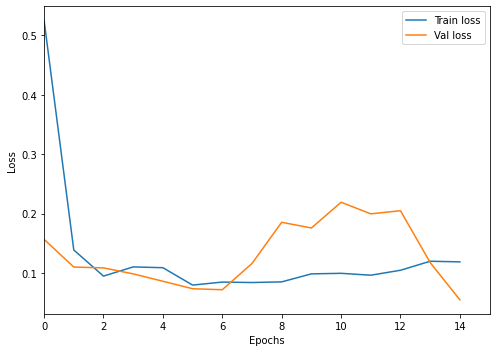

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_loss1, label='Train loss')
plt.plot(val_loss1, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 0 + num_epochs)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

---
### Model 2: predicting 1d gain masks for each track

In [7]:
model_vector = MixingModelVector().to(device)

num_trainable_param = sum(p.numel() for p in model_vector.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

129892 trainable parameters


In [ ]:
# weights = './weights/mixmodel_scalar_1s_0006_0.0849.pt'
# model_vector.load_state_dict(torch.load(weights, map_location=device))

In [8]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_vector.parameters(), weight_decay=1e-5)

In [9]:
start_epoch = 0
num_epochs = 7
train_loss2, val_loss2 = train_model(model_vector, criterion, optimizer, start_epoch, num_epochs, 'vector')

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0,   10] loss: 0.081
[0,   20] loss: 0.106
[0,   30] loss: 0.063
Epoch 0 train loss: 0.0894
Epoch 0 val loss: 0.0754
--------------------------------------------------
[1,   10] loss: 0.051
[1,   20] loss: 0.065
[1,   30] loss: 0.049
Epoch 1 train loss: 0.0544
Epoch 1 val loss: 0.0796
--------------------------------------------------
[2,   10] loss: 0.046
[2,   20] loss: 0.059
[2,   30] loss: 0.063
Epoch 2 train loss: 0.0524
Epoch 2 val loss: 0.0710
--------------------------------------------------
[3,   10] loss: 0.037
[3,   20] loss: 0.072
[3,   30] loss: 0.048
Epoch 3 train loss: 0.0498
Epoch 3 val loss: 0.0650
--------------------------------------------------
[4,   10] loss: 0.033
[4,   20] loss: 0.078
[4,   30] loss: 0.054
Epoch 4 train loss: 0.0515
Epoch 4 val loss: 0.0696
--------------------------------------------------
[5,   10] loss: 0.036
[5,   20] loss: 0.080
[5,   30] loss: 0.067
Epoch 5 train loss: 0.0513
Epoch 5 val loss: 0.0431
-------------------------------------

In [ ]:
weights_file = os.path.join(weights_dir, 'mixmodel_vector_1s_{:04d}_{:.3f}.pt'.format(num_epochs, 0.0410)) 
torch.save(model_vector.state_dict(), weights_file)

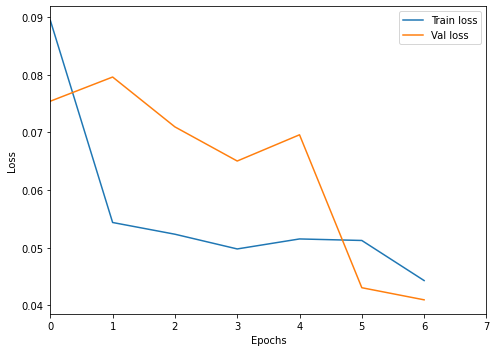

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_loss2, label='Train loss')
plt.plot(val_loss2, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 0 + num_epochs)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))